# SVM-based Eye Detection
## Use an SVM to detect eyes, given a training image and mask.

In [15]:
import BasicFunctions as bf
import numpy as np
from scipy import signal
from skimage import feature
from skimage import transform
from sklearn import svm
from sklearn import preprocessing
from collections import deque

%matplotlib inline

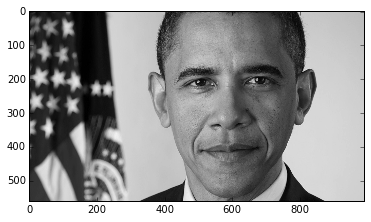

(560, 990)


In [26]:
img = bf.imread("obama.jpg")
img = bf.rgb2gray(img)
bf.imshow(img)

print img.shape

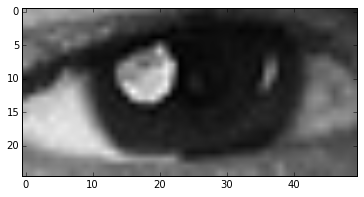

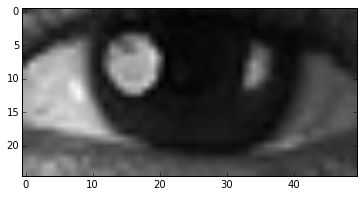

In [17]:
# positive exemplars
eye1_tl = (200, 480)
eye2_tl = (195, 655)

eye1 = img[200:225, 480:530]
bf.imshow(eye1)

eye2 = img[195:220, 655:705]
bf.imshow(eye2)

eye_shape = eye1.shape

In [18]:
def overlapsEye(tl):
    if (((tl[0] < eye1_tl[0]-eye_shape[0]) or (tl[0] > eye1_tl[0]+eye_shape[0])) and
        ((tl[0] < eye2_tl[0]-eye_shape[0]) or (tl[0] > eye2_tl[0]+eye_shape[0])) and
        ((tl[1] < eye1_tl[1]-eye_shape[1]) or (tl[1] > eye1_tl[1]+eye_shape[1])) and
        ((tl[1] < eye2_tl[1]-eye_shape[1]) or (tl[1] > eye2_tl[1]+eye_shape[1]))):
        return False
    return True

def isValid(tl):
    if (tl[0] < img.shape[0]-eye_shape[0]) and (tl[1] < img.shape[1]-eye_shape[1]) and not overlapsEye(tl):
        return True
    return False
    
def extractTL(tl):
    return img[tl[0]:tl[0]+eye_shape[0], tl[1]:tl[1]+eye_shape[1]]
    
# negative exemplars from rest of image
negs = []
num_negs = 0
while num_negs < 100:
    tl = (np.random.randint(0, img.shape[0]), np.random.randint(0, img.shape[1]))
    if isValid(tl):
        num_negs += 1
        negs.append(extractTL(tl))

In [19]:
def jitter(patch):
    f = 10.0
    
    # translate so center is at top left (origin)
    tf = np.matrix([[1, 0, -round(3.5 * eye_shape[1])],
                    [0, 1, -round(3.5 * eye_shape[0])],
                    [0, 0, 1]])
    
    # scale
    tf = np.matrix([[1/f, 0, 0],
                    [0, 1/f, 0],
                    [0, 0, 1]]) * tf
    
    # rotate about z
    theta = 0.1*np.random.randn()
    tf = np.matrix([[np.cos(theta), -np.sin(theta), 0],
                   [np.sin(theta), np.cos(theta), 0],
                   [0, 0, 1]]) * tf

    # now rotate about x
    theta = 0.05*np.random.randn()
    tf = np.matrix([[1, 0, 0],
                    [0, np.cos(theta), -np.sin(theta)],
                    [0, np.sin(theta), np.cos(theta)]]) * tf

    # now rotate about y
    theta = 0.05*np.random.randn()
    tf = np.matrix([[np.cos(theta), 0, np.sin(theta)],
                   [0, 1, 0],
                   [-np.sin(theta), 0, np.cos(theta)]]) * tf

    # scale back
    tf = np.matrix([[f, 0, 0],
                    [0, f, 0],
                    [0, 0, 1]]) * tf
    
    # translate back
    tf = np.matrix([[1, 0, round(3.5 * eye_shape[1])],
                    [0, 1, round(3.5 * eye_shape[0])],
                    [0, 0, 1]]) * tf
                    
    return transform.warp(patch, tf)

def eye2patch(tl):
    return img[tl[0]-3*eye_shape[0]:tl[0]+4*eye_shape[0], 
               tl[1]-3*eye_shape[1]:tl[1]+4*eye_shape[1]]

def patch2eye(patch):
    return patch[3*eye_shape[0]:-3*eye_shape[0], 3*eye_shape[1]:-3*eye_shape[1]]

# create more positive exemplars by applying random small 3D rotations to each eye
eyes = [eye1, eye2]
num_eyes = len(eyes)
patches = deque([eye2patch(eye1_tl), eye2patch(eye2_tl)])
while num_eyes < 100:
    patch = patches.popleft()
    jittered = jitter(patch)
    patches.append(patch)
    eyes.append(patch2eye(jittered))
    num_eyes += 1

In [21]:
# compute HOG for eyes and negs
eyes_hog = []
for eye in eyes:
    eyes_hog.append(bf.getHog(eye))

negs_hog = []
for neg in negs:
    negs_hog.append(bf.getHog(neg))

In [22]:
# set up training dataset
training_set = np.vstack((eyes_hog, negs_hog))

training_labels = np.ones(num_eyes + num_negs)
training_labels[num_eyes:] = 0

scaler = preprocessing.StandardScaler().fit(training_set)
training_set = scaler.transform(training_set)

In [23]:
# train SVM
weights = {0 : 1.0, 1 : 1.0}
clf = svm.SVC(C=1.0, kernel="linear", class_weight=weights)
clf.fit(training_set, training_labels)

SVC(C=1.0, cache_size=200, class_weight={0: 1.0, 1: 1.0}, coef0=0.0, degree=3,
  gamma=0.0, kernel='linear', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False)

In [28]:
def testWindow(tl):
    window = extractTL(tl)
    window_hog = scaler.transform(bf.getHog(window))
    label = clf.predict(window_hog)
    score = clf.decision_function(window_hog)
    return score

def flat2ind(n):
    ncol = img.shape[1] - eye_shape[1]
    i = n / ncol
    j = n % ncol
    return (i, j)

def ind2flat(i, j):
    return i*img.shape[1] + j

# test SVM on sliding window
scores = map(lambda n : testWindow(flat2ind(n)), range(175*(img.shape[1]-eye_shape[1]), 250*(img.shape[1]-eye_shape[1])))

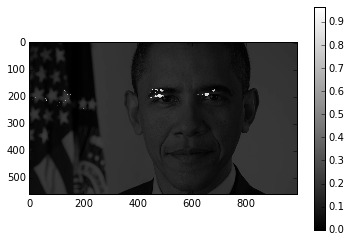

In [29]:
scores = np.array(scores).reshape((250-175, img.shape[1]-eye_shape[1]))
matches = np.zeros(scores.shape)
matches[scores > 0] = 1.0
display = 0.25*img
display[175:250, :scores.shape[1]] += 0.75*matches
bf.imshow(display, cbar=True)

In [30]:
print scores[scores>0]

[  8.50645743e-02   8.78525037e-02   1.08235552e-01   1.04985764e-01
   1.97525892e-01   2.66701636e-01   2.11679589e-01   2.00331193e-01
   1.60292011e-01   1.42617475e-01   1.76391913e-01   2.92414543e-01
   2.78124320e-01   1.87555941e-01   9.67148375e-02   1.48528894e-01
   1.79946234e-01   1.74783721e-01   1.51252263e-01   9.46359602e-02
   7.23210025e-02   1.54646154e-01   2.17685848e-01   2.43357179e-01
   2.37423284e-01   1.86817253e-01   1.98049708e-01   1.31399537e-01
   7.24260600e-02   6.08933609e-02   1.21424979e-01   2.13634118e-01
   1.77972440e-01   1.85202041e-01   2.02928643e-01   1.97089820e-01
   1.70396174e-01   8.15498336e-02   1.00449568e-02   2.05798117e-03
   7.03660217e-02   1.23651069e-01   6.45330836e-02   2.52602191e-02
   5.79957215e-02   9.17089991e-03   1.49762978e-03   1.36237967e-02
   4.28696356e-02   4.62798163e-04   2.59956829e-02   6.77828681e-02
   7.83197049e-03   5.76014664e-02   1.67465558e-01   1.78968933e-01
   1.43362845e-01   6.75699920e-02

In [32]:
print scores[scores > 0.9]

[ 0.90117347  0.92954699  0.95807205  0.9960052   0.92815513  1.07626352
  1.08341358  1.10673933  1.16674452  1.13354184  1.05121768  1.16373515
  1.2265409   1.32873288  1.30007953  1.23301054  1.13021126  0.95529206
  1.12024173  1.20429051  1.25799038  1.23945109  1.17663259  1.07441797
  0.90417613  1.0608679   1.15293094  1.19456825  1.13804928  1.09402782
  0.99061544  0.90402474  0.90653936  0.99346959  1.09513463  1.10060111
  1.05228314  0.98203131  0.98221994  1.20695339  1.17595943  1.15527729
  1.06385828  0.98986395  0.91849436  0.92523029  1.02628289  1.08111762
  1.29798655  1.26952576  1.27358477  1.22676834  1.09763856  0.96879352
  0.97873138  1.10921921  1.33034258  1.30024133  1.2906281   1.22374841
  1.02663034  0.93521712  1.03177826  1.18591261  1.19022272  1.16580201
  1.08949789  0.93687978  1.06503625  1.07654405  1.02396128  0.93712016]


In [35]:
sy, sx = img.shape
cx, cy = (8, 8)

n_cellsx = int(np.floor(sx // cx))  # number of cells in x
n_cellsy = int(np.floor(sy // cy))  # number of cells in y
print sx / cx, sx // cx

print np.index_exp[cy // 2:cy * n_cellsy:cy, cx // 2:cx * n_cellsx:cx]

123 123
(slice(4, 560, 8), slice(4, 984, 8))
